### Isak Andersson AI23 - Maskininlärning
# Laboration

#### Uppgift 1 - Klassificering av hjärt- och kärlsjukdom
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/cardio_train.csv', sep=';').drop('id', axis=1)

### 1. Introduction

This report focuses on the relation of BMI and blood pressure to the risk of being afflicted by a cardivascular disease, and aims to prove their correlation by using machine-learning classification and regression models.



**FYLL PÅ**

### 2. Method

Since the data originally contained outlandish and impossible datapoints, it was arbitrarily "cleaned" by the author as follows:

In [2]:
df = df.query('140 < height < 230')
df = df.query('40 < weight < 190')
df = df.query('60 < ap_hi < 250')
df = df.query('30 < ap_lo < 140')
df['age'] = (df['age'] / 365.25)
df = df.query('age > 35')
df = pd.get_dummies(columns=['gender'], data=df, drop_first=True, dtype=int, prefix='male')

- The height and weight limits was chosen solely to remove the end points of data. This was done since there's no real way to determine if there's any truth to the outliers, and thus, guessed. This, in some way or another, goes for the rest of the oulier eliminations aswell.
- The value limits for blood pressure (ap_hi (systolic) & ap_lo (diastolic)) was chosen after limited research found that the most extreme online [references](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1087497/) made the cut at 70 < ap_hi < 250, and 40 < ap_lo < 130. Therefore, in this report, the values are taken to even slightly lower/higher extremes to not miss out on valuable data.
- The age was made into years instead of the original days, and then also removed the very young outliers.
- The gender feature was also categorized as "1" and "2" for women and men respectivly. The piece of code above changes it to the standard binary format of "0" and "1". 

What is left of the original dataset is all but 1604 of the original 70000. See below fig for an overview of the distribution:

*(please see "slask.ipynb" for source code)*

<img src="data/cardio_overview.png" width="1400" height="650">

On top of this initial clean, the weight, height and the blood pressure stats were re-configured to categorically show which BMI and blood pressure category the patient belongs to, as follows:

[BMI-wiki](https://en.wikipedia.org/wiki/Body_mass_index)
[Blood pressure - healthline](https://www.healthline.com/health/high-blood-pressure-hypertension#definition)

### $BMI = \frac{weight_{kg}}{height_m^2}$ 
<img src="data/bp-cat.png" width="500" height="400"> <img src="data/bmi-cat.png" width="500" height="400">

*Please note that for this report no counts below "Normal weight" will be accounted for, and simply be removed from our working data. This based on wishes in the assignment.*

In [3]:
df['BMI'] = df['weight'] / (df['height'] / 100)**2 # Divided på 100 to convert cm to m.
df = df.query('BMI >= 18.5') # Removed underweight patients.

bmi_categories = pd.cut(df['BMI'], [18.5, 24.9, 29.9, 34.9, 40, np.inf], labels=['Normal weight', 'Overweight', 'Obese (class I)', 'Obese (class II)', 'Obese (class III)'])
bmi_categories = pd.get_dummies(bmi_categories, drop_first=False, dtype=int)
df = pd.concat([df, bmi_categories], axis=1)

# The pd.cut() function had trouble taking more than one column as input, which is why it is done in a "clunkier" way.
df['BP Healthy'] = ((df['ap_hi'] < 120) & (df['ap_lo'] < 80)).astype(int)
df['BP Elevated'] = ((df['ap_hi'] >= 120) & (df['ap_hi'] < 130) & (df['ap_lo'] < 80)).astype(int)
df['BP Hypertension (stage 1)'] = (((df['ap_hi'] >= 130) & (df['ap_hi'] < 140)) | ((df['ap_lo'] >= 80) & (df['ap_lo'] < 90))).astype(int)
df['BP Hypertension (stage 2)'] = ((df['ap_hi'] >= 140) | (90 <= df['ap_lo'])).astype(int)
df['BP Hypertensive Crisis'] = ((df['ap_hi'] >= 180) | (120 < df['ap_lo'])).astype(int)

### 4. Analasys

The correlation matrix below shows an overall very gray color, which in this case means there's not a lot of correlation going on, at least not to the naked eye. The most significant correlations noticable with whether or not someone is afflicted by cardivascular disease is "age", "cholestorol" and the blood pressure categories of "Healthy" and "Hypertension (stage 2)", where none of these still aren't correlating very much.

The correlation-mapping also leaves out the features 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI', as they have been repacked into categories as forementioned.

Other noticeable correlations are smoking to gender, glucose levels to cholestorol and the seemingly unimportant factor of physical activity ("active") to anything else!

<Axes: >

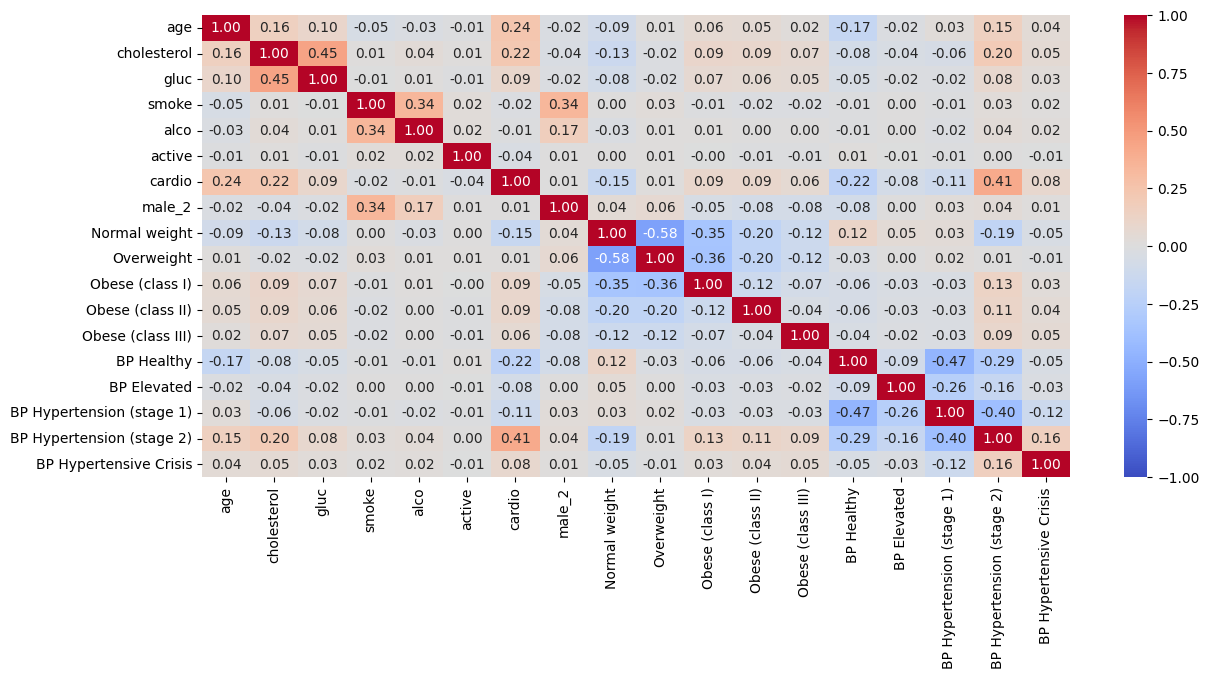

In [4]:
df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo', 'BMI'], inplace=True)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV, Lasso, Ridge, RidgeCV

scaler = MinMaxScaler()

X, y = df.drop(columns=['cardio', 'active'], axis=1), df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# pipe_log = make_pipeline(scaler, LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear'))
# pipe_sgd = make_pipeline(scaler, SGDClassifier())

# param_grid = {'logisticregression__C': np.linspace(1, 10, 5).astype(float)}
# param_sgd = {'sgdclassifier__alpha': np.linspace(0.00001, 0.0001, 5).astype(float)}

# log_reg_cv = GridSearchCV(pipe_log, param_grid, cv=5)
# sgd_grid_cv = GridSearchCV(pipe_sgd, param_sgd, cv=5)

# log_reg_cv.fit(X_train, y_train)
# sgd_grid_cv.fit(X_train, y_train)

# pipe_lasso = make_pipeline(scaler, LassoCV(cv=5))
# lasso_grid = {'lassocv__n_alphas': [100, 200, 300], 'lassocv__eps': [0.001, 0.01, 0.1]}
# lasso_cv = GridSearchCV(pipe_lasso, lasso_grid, cv=5)

# lasso_cv.fit(X_train, y_train)

pipe_ridge = make_pipeline(scaler, RidgeCV(cv=5))
ridge_grid = {'ridgecv__alphas': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
ridge_cv = GridSearchCV(pipe_ridge, ridge_grid, cv=5, scoring='neg_mean_squared_error')

ridge_cv.fit(X_train, y_train)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\linear_model\_ridge.py", line 2418, in fit
    super().fit(X, y, sample_weight=sample_weight)
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\linear_model\_ridge.py", line 2240, in fit
    gs.fit(X, y, sample_weight=sample_weight)
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\model_selection\_search.py", line 970, in fit
    self._run_search(evaluate_candidates)
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\model_selection\_search.py", line 1527, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\isaka\.virtualenvs\MachineLearning-Isak-Andersson-nqPwo2ln\Lib\site-packages\sklearn\model_selection\_search.py", line 136, in __init__
    if len(value) == 0:
       ^^^^^^^^^^
TypeError: len() of unsized object


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# print(log_reg_cv.best_params_)
# print(sgd_grid_cv.best_params_)
# print(lasso_cv.best_params_)

# y_pred_log = log_reg_cv.predict(X_test)
# y_pred_sgd = sgd_grid_cv.predict(X_test)
# y_pred_lasso = lasso_cv.predict(X_test)

# print(classification_report(y_test, y_pred_log))
# print(classification_report(y_test, y_pred_sgd))
# print(classification_report(y_test, y_pred_lasso))

# ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log)).plot()
# ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sgd)).plot()
# ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lasso)).plot()

{'lassocv__eps': 0.001, 'lassocv__n_alphas': 100}
